In [16]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [17]:
# Create a scaler object
scaler = MinMaxScaler()

In [18]:
dataset = pd.read_csv('./datasets/Band_dataset_GBSM_AAPA - Sheet1.csv')

In [19]:
dataset

,COMP,x,y,band1,band2,band3,band4,ndvi,N_Actual,P_Actual,K_Actual
0,AAPA,7391,766,706,629,388,2649,0.744485,2.07,0.165,0.69
1,AAPA,7381,1065,679,535,323,2819,0.794398,3.03,0.187,0.51
2,AAPA,7308,1074,670,523,315,2583,0.782609,3.06,0.178,0.55
3,AAPA,7255,1184,695,550,342,2602,0.767663,2.86,0.181,0.56
4,AAPA,7082,839,683,564,370,2516,0.743590,2.95,0.187,0.58
...,...,...,...,...,...,...,...,...,...,...,...
705,GBSM,35,531,243,408,278,3287,0.862323,2.24,0.170,0.96
706,GBSM,34,633,236,429,275,3356,0.868597,2.94,0.200,1.28
707,GBSM,33,531,245,403,286,3314,0.862321,2.40,0.160,1.21
708,GBSM,33,545,226,383,284,3263,0.870450,2.91,0.170,1.20


In [20]:
dataset = dataset[['band1', 'band2', 'band3', 'band4', 'ndvi', 'N_Actual', 'P_Actual', 'K_Actual']]

In [21]:
bands = ['band1', 'band2', 'band3', 'band4']

# Normalize the selected bands
dataset[bands] = scaler.fit_transform(dataset[bands])

/var/folders/9z/n3j81_ls7r5_5wm38p_06kbw0000gn/T/ipykernel_24075/3663055858.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[bands] = scaler.fit_transform(dataset[bands])


In [22]:
dataset

,band1,band2,band3,band4,ndvi,N_Actual,P_Actual,K_Actual
0,0.914286,0.700483,0.396414,0.605311,0.744485,2.07,0.165,0.69
1,0.873684,0.549114,0.266932,0.656608,0.794398,3.03,0.187,0.51
2,0.860150,0.529791,0.250996,0.585395,0.782609,3.06,0.178,0.55
3,0.897744,0.573269,0.304781,0.591129,0.767663,2.86,0.181,0.56
4,0.879699,0.595813,0.360558,0.565178,0.743590,2.95,0.187,0.58
...,...,...,...,...,...,...,...,...
705,0.218045,0.344605,0.177291,0.797827,0.862323,2.24,0.170,0.96
706,0.207519,0.378422,0.171315,0.818648,0.868597,2.94,0.200,1.28
707,0.221053,0.336554,0.193227,0.805975,0.862321,2.40,0.160,1.21
708,0.192481,0.304348,0.189243,0.790585,0.870450,2.91,0.170,1.20


BUILD MODEL

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np

In [24]:
print(f"PyTorch version: {torch.__version__}")
print(f"MPS (Metal Performance Shaders) available: {torch.backends.mps.is_available()}")
print(f"Built with MPS: {torch.backends.mps.is_built()}")

PyTorch version: 2.7.0.dev20250112
MPS (Metal Performance Shaders) available: True
Built with MPS: True


In [25]:
# Sample Dataset class
class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.features = dataframe[['band1', 'band2', 'band3', 'band4', 'ndvi']].values
        self.targets = dataframe[['N_Actual', 'P_Actual', 'K_Actual']].values

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        x = torch.tensor(self.features[idx], dtype=torch.float32)
        y = torch.tensor(self.targets[idx], dtype=torch.float32)
        return x, y

# Define the Neural Network
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

In [26]:
#dataframe = pd.DataFrame(dataset)

# Split data into training and validation sets
train_df = dataset.sample(frac=0.7, random_state=42)
val_df = dataset.drop(train_df.index)

# Create datasets and dataloaders
train_dataset = CustomDataset(train_df)
val_dataset = CustomDataset(val_df)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [27]:
print("Train dataset length", train_dataset.__len__())
print("Val dataset length", val_dataset.__len__())

Train dataset length 497
Val dataset length 213


In [29]:
# Model, Loss, and Optimizer
input_size = 5  # Number of input features
hidden_size = 64  # Hidden layer size
output_size = 3  # Number of targets (N, P, K)

model = NeuralNet(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [30]:
import matplotlib.pyplot as plt



# Lists to store losses for plotting
train_losses = []
val_losses = []

epochs = 1000

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=50, save_path="best_model.pth"):
    best_val_loss = float('inf')

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0

        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        # Save the best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f'./models/{save_path}')
            print(f"Best model saved with Val Loss: {best_val_loss:.4f}")

In [31]:
train_model(model, train_loader, val_loader, criterion, optimizer, epochs=1000, save_path='best_model_macro_npk.pth')

Epoch [1/1000], Train Loss: 2.5109, Val Loss: 2.4595
Best model saved with Val Loss: 2.4595
Epoch [2/1000], Train Loss: 2.2510, Val Loss: 2.1961
Best model saved with Val Loss: 2.1961
Epoch [3/1000], Train Loss: 1.9920, Val Loss: 1.9368
Best model saved with Val Loss: 1.9368
Epoch [4/1000], Train Loss: 1.7525, Val Loss: 1.6767
Best model saved with Val Loss: 1.6767
Epoch [5/1000], Train Loss: 1.4862, Val Loss: 1.4094
Best model saved with Val Loss: 1.4094
Epoch [6/1000], Train Loss: 1.2216, Val Loss: 1.1440
Best model saved with Val Loss: 1.1440
Epoch [7/1000], Train Loss: 0.9687, Val Loss: 0.8861
Best model saved with Val Loss: 0.8861
Epoch [8/1000], Train Loss: 0.7354, Val Loss: 0.6515
Best model saved with Val Loss: 0.6515
Epoch [9/1000], Train Loss: 0.5106, Val Loss: 0.4513
Best model saved with Val Loss: 0.4513
Epoch [10/1000], Train Loss: 0.3486, Val Loss: 0.2990
Best model saved with Val Loss: 0.2990
Epoch [11/1000], Train Loss: 0.2157, Val Loss: 0.1906
Best model saved with Val

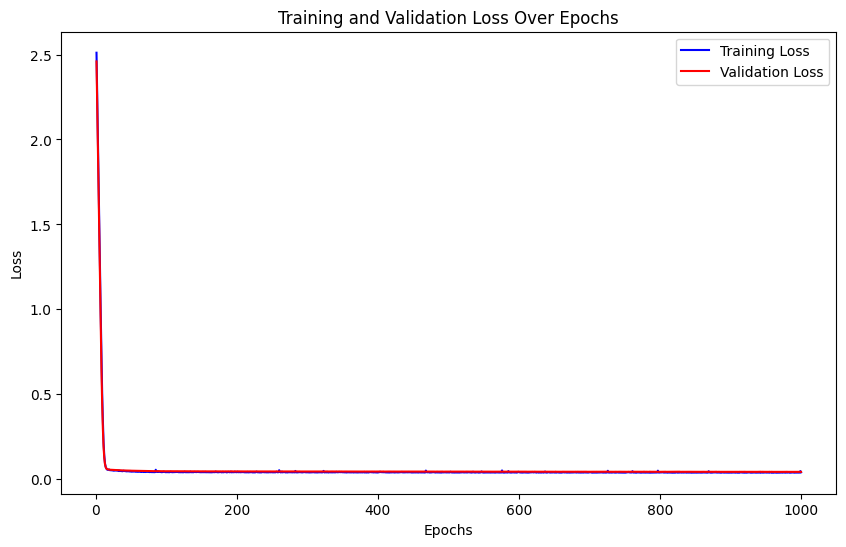

In [32]:

    # Plotting the loss graph
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, epochs+1), train_losses, label='Training Loss', color='blue')
    plt.plot(range(1, epochs+1), val_losses, label='Validation Loss', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.show()

EVALUATE

In [36]:
test_data = val_df[['band1','band2','band3', 'band4', 'ndvi']].values

In [42]:
predicted = model(torch.tensor(test_data, dtype=torch.float32))

In [49]:
output = predicted.detach().numpy()

In [55]:
out_dataframe = pd.DataFrame(output,columns=['N_pred', 'P_Pred', 'K_pred'])
out_dataframe 

,N_pred,P_Pred,K_pred
0,2.681773,0.169148,0.710365
1,2.543730,0.152549,0.600656
2,2.538013,0.150484,0.566099
3,2.625219,0.162701,0.649228
4,2.538230,0.153070,0.587712
...,...,...,...
208,2.538183,0.159496,1.029733
209,2.531534,0.159903,1.030566
210,2.514443,0.159359,1.046363
211,2.521100,0.159108,1.056813


In [58]:
valid_dataframe = val_df.reset_index()
valid_dataframe

,index,band1,band2,band3,band4,ndvi,N_Actual,P_Actual,K_Actual
0,1,0.873684,0.549114,0.266932,0.656608,0.794398,3.03,0.187,0.51
1,4,0.879699,0.595813,0.360558,0.565178,0.743590,2.95,0.187,0.58
2,13,0.866165,0.645733,0.354582,0.548280,0.740361,2.74,0.181,1.13
3,14,0.885714,0.565217,0.290837,0.593543,0.772496,2.90,0.160,0.64
4,20,0.851128,0.576490,0.308765,0.496681,0.738701,2.77,0.189,1.09
...,...,...,...,...,...,...,...,...,...
208,692,0.231579,0.388084,0.201195,0.898914,0.869902,2.71,0.160,1.12
209,698,0.210526,0.365539,0.179283,0.857574,0.872146,2.57,0.160,1.24
210,700,0.193985,0.334944,0.175299,0.816838,0.873078,2.85,0.180,1.17
211,703,0.213534,0.351047,0.199203,0.890163,0.874772,2.93,0.180,1.14


In [63]:
merge_dataframe = pd.concat([valid_dataframe, out_dataframe], axis=1)
merge_dataframe 

,index,band1,band2,band3,band4,ndvi,N_Actual,P_Actual,K_Actual,N_pred,P_Pred,K_pred
0,1,0.873684,0.549114,0.266932,0.656608,0.794398,3.03,0.187,0.51,2.681773,0.169148,0.710365
1,4,0.879699,0.595813,0.360558,0.565178,0.743590,2.95,0.187,0.58,2.543730,0.152549,0.600656
2,13,0.866165,0.645733,0.354582,0.548280,0.740361,2.74,0.181,1.13,2.538013,0.150484,0.566099
3,14,0.885714,0.565217,0.290837,0.593543,0.772496,2.90,0.160,0.64,2.625219,0.162701,0.649228
4,20,0.851128,0.576490,0.308765,0.496681,0.738701,2.77,0.189,1.09,2.538230,0.153070,0.587712
...,...,...,...,...,...,...,...,...,...,...,...,...
208,692,0.231579,0.388084,0.201195,0.898914,0.869902,2.71,0.160,1.12,2.538183,0.159496,1.029733
209,698,0.210526,0.365539,0.179283,0.857574,0.872146,2.57,0.160,1.24,2.531534,0.159903,1.030566
210,700,0.193985,0.334944,0.175299,0.816838,0.873078,2.85,0.180,1.17,2.514443,0.159359,1.046363
211,703,0.213534,0.351047,0.199203,0.890163,0.874772,2.93,0.180,1.14,2.521100,0.159108,1.056813


In [66]:
merge_dataframe.to_excel('./datasets/result_macro_npk.xlsx')